# This is a tool for looking at HDX/MS data, LacI structure, and mutational phenotypes for particular LacI peptides in one or more functional states.

![LacI peptides and structure.](lacI_diagram.png)

### First choose the state(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytraj as pt
import nglview as nv
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import seaborn as sns
import ipywidgets as widgets

print('Choose from the following functional states: ')
CBwidget_IPTG = widgets.Checkbox(description = 'IPTG, an inducer molecule', value=True, disabled=False)
CBwidget_ONPF = widgets.Checkbox(description = 'ONPF, an anti-inducer molecule', value=True, disabled=False)
CBwidget_APO = widgets.Checkbox(description = 'APO protein', value=True, disabled=False)
CBwidget_DNA = widgets.Checkbox(description = 'operator DNA', value=True, disabled=False)
CBwidget_TMG = widgets.Checkbox(description = 'TMG, an inducer molecule', value=True, disabled=False)
CBwidget_ONPFDNA = widgets.Checkbox(description = 'ONPF and operator DNA', value=True, disabled=False)

display(CBwidget_IPTG, CBwidget_ONPF, CBwidget_APO, CBwidget_DNA, CBwidget_TMG, CBwidget_ONPFDNA)

Choose from the following functional states: 


Checkbox(value=True, description='IPTG, an inducer molecule')

Checkbox(value=True, description='ONPF, an anti-inducer molecule')

Checkbox(value=True, description='APO protein')

Checkbox(value=True, description='operator DNA')

Checkbox(value=True, description='TMG, an inducer molecule')

Checkbox(value=True, description='ONPF and operator DNA')

Run the next block to confirm choices.

In [2]:
states_list = []

if CBwidget_IPTG.value == True:
    states_list.append('IPTG')
if CBwidget_ONPF.value == True:
    states_list.append('ONPF')
if CBwidget_APO.value == True:
    states_list.append('APO')
if CBwidget_DNA.value == True:
    states_list.append('DNA')
if CBwidget_TMG.value == True:
    states_list.append('TMG')
if CBwidget_ONPFDNA.value == True:
    states_list.append('ONPFDNA')

print('Chosen states:'); print(*states_list)

compiled_file = pd.ExcelFile('20200922_compiled_rates.xlsx')
EOF_file = pd.ExcelFile('error_of_fit.xlsx')

states_dict = {}
peptide_states_list = ['peptide']
for state in states_list:
    states_dict[state] = pd.read_excel(compiled_file, state)
    peptide_states_list.append(state)
    
EOF_df = pd.read_excel(EOF_file, usecols = peptide_states_list)

# Make dictionaries to organize mutation information
MH_dict = {}
with open("MH_groups.txt") as file:
    for line in file:
        (key, val) = line.split()
        MH_dict[int(key)] = val

mutation_dict = {}
with open("single_mutants.txt") as file:
    for line in file:
        (key, val) = line.split()
        mutation_dict[key] = val
        
MHdescriptions_dict = {}
with open("MHgroups_descriptions.txt") as file:
    for line in file:
        (key, val) = line.split(':')
        MHdescriptions_dict[key] = val

Chosen states:
IPTG ONPF APO DNA TMG ONPFDNA


### Next, choose a peptide.

In [3]:
single_state_dict = states_dict.get(states_list[0])
all_peptides = single_state_dict[['peptide']].values.tolist()
all_peptides_2 = []
first_res = single_state_dict[['first_res']].values.tolist()
index = 0

while index < len(all_peptides):
    current_first_res = str(int(first_res[index][0]))
    all_peptides_2.append(current_first_res + ' - ' + all_peptides[index][0])
    index = index + 1

DDwidget = widgets.Dropdown(
    options = all_peptides_2,
    value = '63 - LIGVA',
    description = 'Peptide 1:',
    disabled = False,
)

DDwidget2 = widgets.Dropdown(
    options = all_peptides_2,
    value = '63 - LIGVA',
    description = 'Peptide 2:',
    disabled = False,
)

display(DDwidget)
display(DDwidget2)

Dropdown(description='Peptide 1:', options=('63 - LIGVA', '72 - ALHAP', '72 - ALHAPSQIVA', '72 - ALHAPSQIVAA',…

Dropdown(description='Peptide 2:', options=('63 - LIGVA', '72 - ALHAP', '72 - ALHAPSQIVA', '72 - ALHAPSQIVAA',…

Run the next block to confirm your peptide choice.

In [4]:
peptide_input1 = str(DDwidget.value)
peptide_input1 = peptide_input1.split()[-1]

peptide_input2 = str(DDwidget2.value)
peptide_input2 = peptide_input2.split()[-1]

list_states = states_dict.keys()
peptide_dict1 = dict.fromkeys(list_states, peptide_input1)

for key in peptide_dict1:
    peptide1_df = states_dict[key]
    peptide1_df = peptide1_df[peptide1_df["peptide"] == peptide_input1]
    peptide1_df = peptide1_df[['first_res','last_res','peptide','k1','k2','k3','A','B','C']]
    peptide_dict1[key] = peptide1_df

peptide1_first_res = int(peptide1_df['first_res'])
peptide1_last_res = int(peptide1_df['last_res'])
print('Peptide 1: ' + peptide_input1 + ", residues " + str(peptide1_first_res) + "-" + str(peptide1_last_res))

list_states = states_dict.keys()
peptide_dict2 = dict.fromkeys(list_states, peptide_input2)

for key in peptide_dict2:
    peptide2_df = states_dict[key]
    peptide2_df = peptide2_df[peptide2_df["peptide"] == peptide_input2]
    peptide2_df = peptide2_df[['first_res','last_res','peptide','k1','k2','k3','A','B','C']]
    peptide_dict2[key] = peptide2_df
    
peptide1_EOF_df = EOF_df[EOF_df['peptide'] == peptide_input1]
peptide2_EOF_df = EOF_df[EOF_df['peptide'] == peptide_input2]
peptide1_EOF_dict = {}
peptide2_EOF_dict = {}
for state in states_list:
    peptide1_EOF_dict[state] = peptide1_EOF_df.iloc[0][state]
    peptide2_EOF_dict[state] = peptide2_EOF_df.iloc[0][state]

peptide2_first_res = int(peptide2_df['first_res'])
peptide2_last_res = int(peptide2_df['last_res'])
print('Peptide 2: ' + peptide_input2 + ", residues " + str(peptide2_first_res) + "-" + str(peptide2_last_res))

Peptide 1: LAQRVSGL, residues 115-122
Peptide 2: LAGPLSSVSARL, residues 185-196


### Fit deuterium uptake functions for each peptide for each state.

In [5]:
fit_dict1 = dict.fromkeys(list_states)
fit_dict2 = dict.fromkeys(list_states)

for key in peptide_dict1:
    current_table = peptide_dict1.get(key)

    N1 = current_table['A'] + current_table['B'] + current_table['C']

    k1 = current_table['k1']
    k2 = current_table['k2']
    k3 = current_table['k3']
    A = current_table['A']
    B = current_table['B']
    C = current_table['C']

    t = np.logspace(0, 4.5, 1000)
    fit_data = []

    for timepoint in t:
        fit_item = N1 - ( A*np.exp(-k1*timepoint) + B*np.exp(-k2*timepoint) + C*np.exp(-k3*timepoint) )
        fit_data.append(float(fit_item))
    
    fit_dict1[key] = fit_data
    
for key in peptide_dict2:
    current_table = peptide_dict2.get(key)

    N2 = current_table['A'] + current_table['B'] + current_table['C']

    k1 = current_table['k1']
    k2 = current_table['k2']
    k3 = current_table['k3']
    A = current_table['A']
    B = current_table['B']
    C = current_table['C']

    t = np.logspace(0, 4.5, 1000)
    fit_data = []

    for timepoint in t:
        fit_item = N2 - ( A*np.exp(-k1*timepoint) + B*np.exp(-k2*timepoint) + C*np.exp(-k3*timepoint) )
        fit_data.append(float(fit_item))
    
    fit_dict2[key] = fit_data

print('Fits complete!')

Fits complete!


### Compile mutational phenotype data for Peptide 1.


-------- Mutational phenotype data from Markiewicz et al., J. Mol Biol., 1994 --------

Peptide 1: LAQRVSGL

L115: group 15
Interface between headpiece of protomer A and core of protomer B, or interface between headpieces A and B - intolerant to substitutions
Mutations that do not affect the phenotype: Y H A C E F G K P Q R S
Mutations causing small effects on phenotype: 
Mutations causing dramatic effects on phenotype: 

A116: group 15
Interface between headpiece of protomer A and core of protomer B, or interface between headpieces A and B - intolerant to substitutions
Mutations that do not affect the phenotype: H C E G P Q R S
Mutations causing small effects on phenotype: Y L F K
Mutations causing dramatic effects on phenotype: 

Q117: group 15
Interface between headpiece of protomer A and core of protomer B, or interface between headpieces A and B - intolerant to substitutions
Mutations that do not affect the phenotype: Y H E F G K R S
Mutations causing small effects on phenotype: 

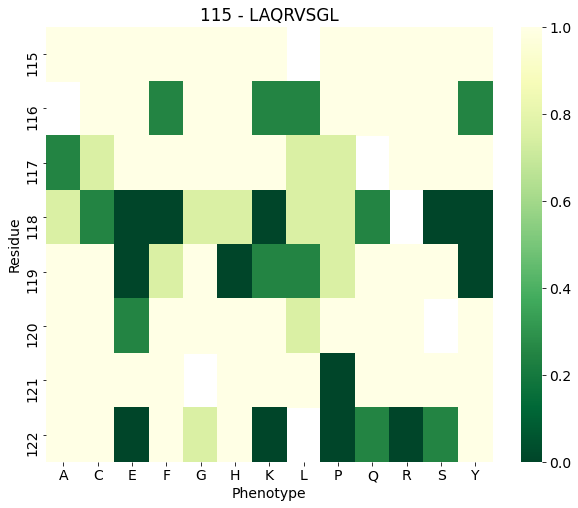

In [6]:
# This section controls the mutation information.

peptide1_range = range(peptide1_first_res, peptide1_last_res + 1, 1)

print('''
-------- Mutational phenotype data from Markiewicz et al., J. Mol Biol., 1994 --------
''')
print('Peptide 1: ' + peptide_input1)

peptide_index = 0
res_label_value = []
AA_value = []
heatmap_value = []

aa = list("YLHACDEFGIKMNPQRSTVW")

for residue in peptide1_range:
    no_effect = []
    small_effect = []
    dramatic_effect = []
    
    # print MH group
    for key, value in MH_dict.items(): 
        if residue == key:
            peptide_index = peptide_index + 1
            res_label = str(peptide_input1[peptide_index-1]) + str(residue)
            print('\n' + res_label + ': group ' + value)
            # print MH group description
            for second_key, second_value in MHdescriptions_dict.items():
                if value == second_key:
                    print(second_value)
                    
    # group and print phenotype effects of specific point mutations
    for AA in aa:
        for key, value in mutation_dict.items():
            if key[-1] == AA:
                if res_label in key:
                    if value == '+':
                        no_effect.append(key[-1])
                        heatmap_value.append(1)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('+-'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.25)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('-+'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.75)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == '-':
                        dramatic_effect.append(key[-1])
                        heatmap_value.append(0)
                        AA_value.append(AA)
                        res_label_value.append(residue)

    print('Mutations that do not affect the phenotype: ' + " ".join(x for x in no_effect))
    print('Mutations causing small effects on phenotype: ' + " ".join(x for x in small_effect))
    print('Mutations causing dramatic effects on phenotype: ' + " ".join(x for x in dramatic_effect))

heatmap_df = pd.DataFrame({'Phenotype': AA_value, 'Residue': res_label_value, 'Sensitivity': heatmap_value })
# plot it
print('\nHeatmap'
      '\nDarker colors indicate increased disruption to phenotype by mutation.'
      '\nWhite boxes - WT residue.')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DejaVu Sans'
df_wide=heatmap_df.pivot_table( index='Residue', columns='Phenotype', values='Sensitivity' )
p2=sns.heatmap( df_wide, cmap="YlGn_r" )
p2.set_title(str(peptide1_first_res) + ' - ' + peptide_input1)
plt.show()

### Compile mutational phenotype data for Peptide 2.

### Finally, plot the deterium uptake plot to observe the H/D exchange for the peptide in different states. Compare with the protein structure.

In [ ]:
# This section controls the mutation information.

peptide2_range = range(peptide2_first_res, peptide2_last_res + 1, 1)

print('''
-------- Mutational phenotype data from Markiewicz et al., J. Mol Biol., 1994 --------
''')
print('Peptide 2: ' + peptide_input2)

peptide_index = 0
res_label_value = []
AA_value = []
heatmap_value = []

aa = list("YLHACDEFGIKMNPQRSTVW")

for residue in peptide2_range:
    no_effect = []
    small_effect = []
    dramatic_effect = []
    
    # print MH group
    for key, value in MH_dict.items(): 
        if residue == key:
            peptide_index = peptide_index + 1
            res_label = str(peptide_input2[peptide_index-1]) + str(residue)
            print('\n' + res_label + ': group ' + value)
            # print MH group description
            for second_key, second_value in MHdescriptions_dict.items():
                if value == second_key:
                    print(second_value)
                    
    # group and print phenotype effects of specific point mutations
    for AA in aa:
        for key, value in mutation_dict.items():
            if key[-1] == AA:
                if res_label in key:
                    if value == '+':
                        no_effect.append(key[-1])
                        heatmap_value.append(1)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('+-'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.25)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == ('-+'):
                        small_effect.append(key[-1])
                        heatmap_value.append(0.75)
                        AA_value.append(AA)
                        res_label_value.append(residue)
                    elif value == '-':
                        dramatic_effect.append(key[-1])
                        heatmap_value.append(0)
                        AA_value.append(AA)
                        res_label_value.append(residue)

    print('Mutations that do not affect the phenotype: ' + " ".join(x for x in no_effect))
    print('Mutations causing small effects on phenotype: ' + " ".join(x for x in small_effect))
    print('Mutations causing dramatic effects on phenotype: ' + " ".join(x for x in dramatic_effect))

heatmap_df = pd.DataFrame({'Phenotype': AA_value, 'Residue': res_label_value, 'Sensitivity': heatmap_value })
# plot it
print('\nHeatmap'
      '\nDarker colors indicate increased disruption to phenotype by mutation.'
      '\nWhite boxes - WT residue.')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DejaVu Sans'
axes = {'titlesize' : 24,
        'titleweight' : 'bold',
        'labelsize' : 24
       }
df_wide=heatmap_df.pivot_table( index='Residue', columns='Phenotype', values='Sensitivity' )
p2=sns.heatmap( df_wide, cmap="YlGn_r" )
p2.set_title(str(peptide2_first_res) + ' - ' + peptide_input2)
plt.show()

In [ ]:
# This section controls the plot.

print('''
-------- Fitted D uptake plots for selected states with structural representation --------
''')

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 24
       }
axes = {'titlesize' : 24,
        'titleweight' : 'bold',
        'labelsize' : 24
       }

plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', lw = 3)

for state in states_list:
    ax1.plot(t, fit_dict1.get(state), label = state)
    ax1.fill_between(t, fit_dict1.get(state)+peptide1_EOF_dict.get(state), fit_dict1.get(state)-peptide1_EOF_dict.get(state), alpha=0.2)
    ax2.plot(t, fit_dict2.get(state), label = state)
    ax2.fill_between(t, fit_dict2.get(state)+peptide2_EOF_dict.get(state), fit_dict2.get(state)-peptide2_EOF_dict.get(state), alpha=0.2)
    ax1.set_ylabel('# Deuterons')
    ax1.set_xlabel('Time (seconds)')
    ax2.set_xlabel('Time (seconds)')
    ax1.set_title(str(peptide1_first_res) + ' - ' + peptide_input1)
    ax2.set_title(str(peptide2_first_res) + ' - ' + peptide_input2)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.set_ylim(0, int(round(N1)))
    ax2.set_ylim(0, int(round(N2)))


plt.legend(frameon = False, bbox_to_anchor = (1.6, 1))
plt.show()

# This section controls the structure widget.

# view = nv.NGLWidget()
traj = pt.load('2p9h_REDO.pdb')
view = nv.show_pytraj(traj)
view.add_surface(str(peptide1_first_res+2) + "-" + str(peptide1_last_res), color = 'orange', opacity='0.5', wireframe=True)
view.add_ball_and_stick(str(peptide1_first_res+2) + "-" + str(peptide1_last_res))
view.add_surface(str(peptide2_first_res+2) + "-" + str(peptide2_last_res), color = 'lightblue', opacity='0.5', wireframe=True)
view.add_ball_and_stick(str(peptide2_first_res+2) + "-" + str(peptide2_last_res))
# view.add_surface('74-81', color = 'orange', opacity='0.9', wireframe=True)
# view.add_ball_and_stick('246-255')


# view.add_representation('line', selection='water') # uncomment this line to see solvent
view._set_size('800px', '600px')
mat = [59.476009917035874 ,66.10295214971443, -76.02228809508843, 0,
       -55.56959630110223, 95.16365469618486, 39.27191257844691, 0,
       84.029807431962, 16.14505706800799, 79.77915091670029, 0, 
       -22.46560287475586, 17.614827632904053, -10.28352165222168, 1]
view._set_camera_orientation(mat)
print('''
PDB ID: 2P9H (wild-type LacI core domain + IPTG). 
Oriented with the C-terminal subdomain at the top.

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789
''')
print('Peptide ' + peptide_input1 + ', residues ' + str(peptide1_first_res+2) + "-" + str(peptide1_last_res) + 
      ', shown as orange surface and sticks.')
print('Peptide ' + peptide_input2 + ', residues ' + str(peptide2_first_res+2) + "-" + str(peptide2_last_res) + 
      ', shown as blue surface and sticks.')
view

### Determine the statistical difference in H/D exchange over this timecourse among states for Peptide 1.
(less reliable for very slow-exchanging peptides)

In [ ]:
print('''
Independent t-tests
Pairwise tests to determine: is a similar to b? / is a similar to c? / is b similar to c?/ etc.
These test the null hypothesis that pairs of independent samples have identical average (expected) values.
Assumes that the populations have identical variances.
''')

for list1, list2 in combinations(fit_dict1.keys(), 2):
    sig = ""
    t_val, p_val = ttest_ind(fit_dict1[list1], fit_dict1[list2])
    if p_val > 0.05:
        sig = "   p > 0.05"
    if p_val == 0:
        sig = "exchanges very slowly in both states"
    print(list1, list2, "{:.2e}".format(p_val), sig)

print('''
One-way ANOVA
A combined test to determine: are a, b and c drawn from the same group?
This tests the null hypothesis that all groups have the same population mean.
(If there are only two groups, it's the same as a t-test.)
''')

t_val_2, p_val_2 = f_oneway(*fit_dict1.values())
print(*fit_dict1.keys(), "{:.2e}".format(p_val_2))

### Determine the statistical difference in H/D exchange over this timecourse among states for Peptide 2.
(less reliable for very slow-exchanging peptides)

In [ ]:
print('''
Independent t-tests
Pairwise tests to determine: is a similar to b? / is a similar to c? / is b similar to c?/ etc.
These test the null hypothesis that pairs of independent samples have identical average (expected) values.
Assumes that the populations have identical variances.
''')

for list1, list2 in combinations(fit_dict2.keys(), 2):
    sig = ""
    t_val, p_val = ttest_ind(fit_dict2[list1], fit_dict2[list2])
    if p_val > 0.05:
        sig = "   p > 0.05"
    if p_val == 0:
        sig = "exchanges very slowly in both states"
    print(list1, list2, "{:.2e}".format(p_val), sig)

print('''
One-way ANOVA
A combined test to determine: are a, b and c drawn from the same group?
This tests the null hypothesis that all groups have the same population mean.
(If there are only two groups, it's the same as a t-test.)
''')

t_val_2, p_val_2 = f_oneway(*fit_dict2.values())
print(*fit_dict2.keys(), "{:.2e}".format(p_val_2))